# Exploratory Data Analysis (EDA) – Wine Quality Dataset


## 1. Understanding the Data and Business Problem

- **Data Source**: UCI Machine Learning Repository – red wine quality data
- **Objective**: Să identificăm care variabile influențează scorul de calitate al vinului.
- **Structura datelor**: 1599 rânduri (vinuri), 11 caracteristici + 1 scor de calitate (`quality`)
- **Tipuri de date**: Toate variabilele sunt numerice, în afară de eticheta grupată (`quality_grouped`)


In [1]:

# Importăm librăriile necesare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline
sns.set(style='ticks', palette='Set2')


## 2. Data Collection and Preparation

In [2]:

# Citim setul de date
df = pd.read_csv("dataset/winequality-red.csv", sep=';')

# Verificăm valori lipsă și duplicate
print("Valori lipsă pe coloană:\n", df.isnull().sum())
print("Număr rânduri duplicate:", df.duplicated().sum())

# Eliminăm duplicatele
df = df.drop_duplicates()


Valori lipsă pe coloană:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Număr rânduri duplicate: 240


In [3]:

# Grupăm calitatea în low, mediu, high
def map_quality(value):
    if value <= 4:
        return "low"
    elif value <= 6:
        return "mediu"
    else:
        return "high"

df['quality_grouped'] = df['quality'].apply(map_quality)

# Separăm X și y
X = df.drop(columns=['quality', 'quality_grouped'])
y = df['quality_grouped']

# Standardizare
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


## 3. Data Exploration

quality
5    577
6    535
7    167
4     53
8     17
3     10
Name: count, dtype: int64
Distribuție scoruri grupate:
 quality_grouped
high      184
low        63
mediu    1112
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_10332\485964879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_counts.index, y=grouped_counts.values, palette="pastel")


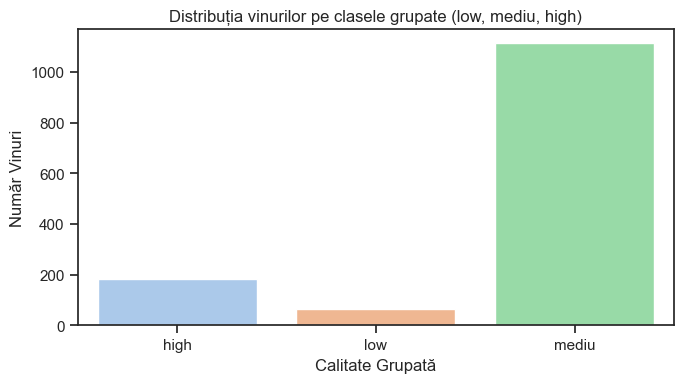

In [4]:

# Distribuție scor original
print(df['quality'].value_counts())

# Distribuție calitate grupată
grouped_counts = df['quality_grouped'].value_counts().sort_index()
print("Distribuție scoruri grupate:\n", grouped_counts)

# Barplot scor grupat
plt.figure(figsize=(7, 4))
sns.barplot(x=grouped_counts.index, y=grouped_counts.values, palette="pastel")
plt.title("Distribuția vinurilor pe clasele grupate (low, mediu, high)")
plt.xlabel("Calitate Grupată")
plt.ylabel("Număr Vinuri")
plt.tight_layout()
plt.show()


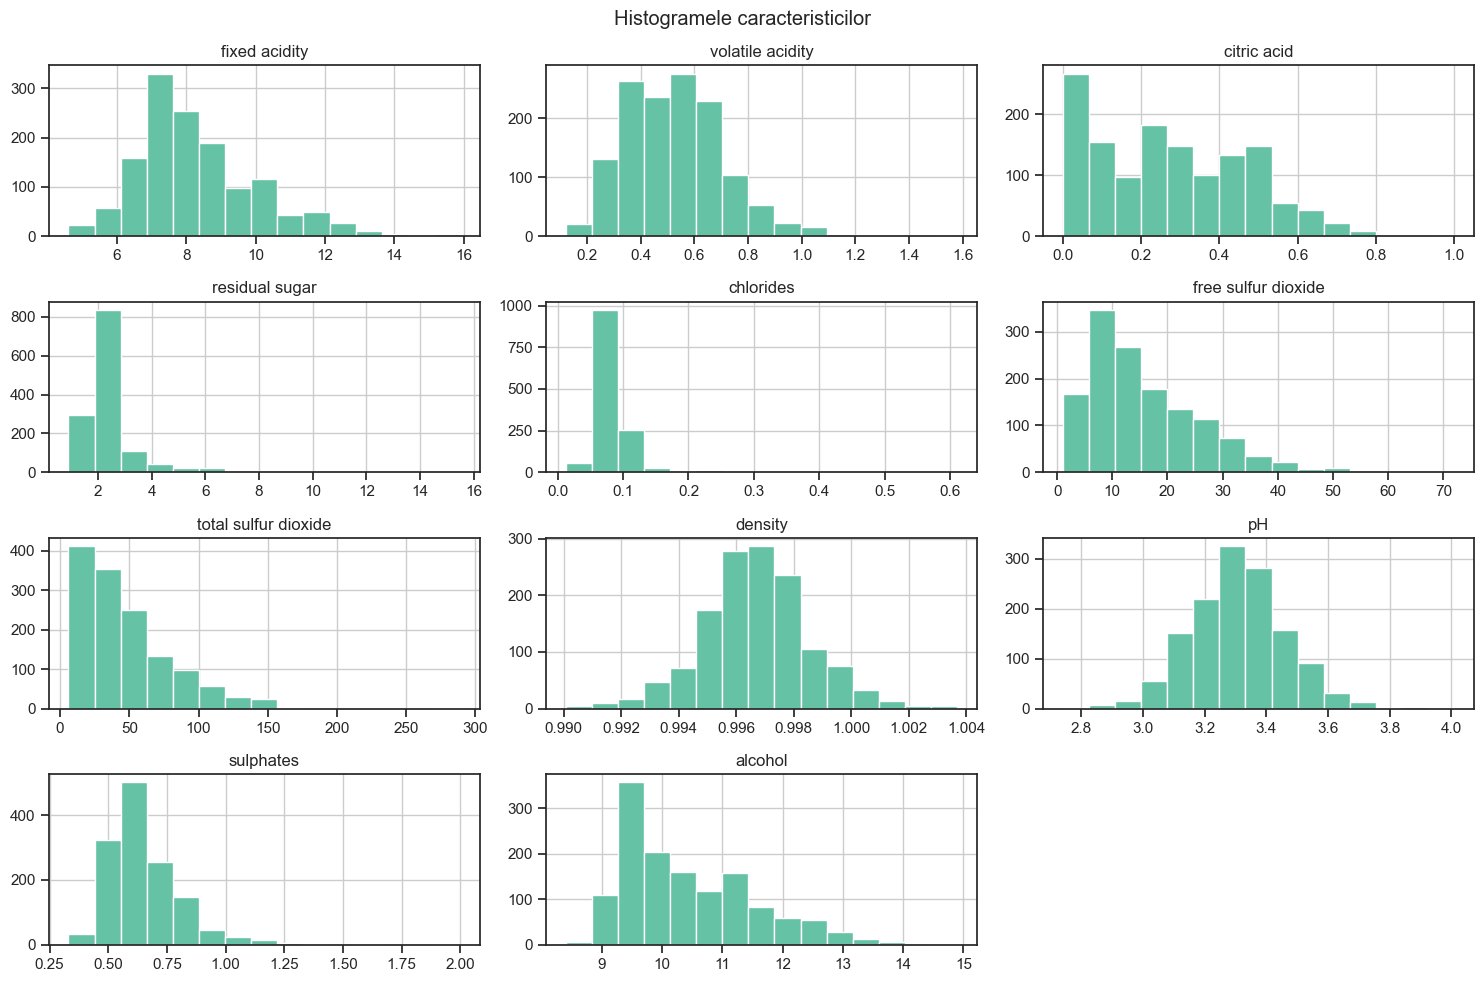

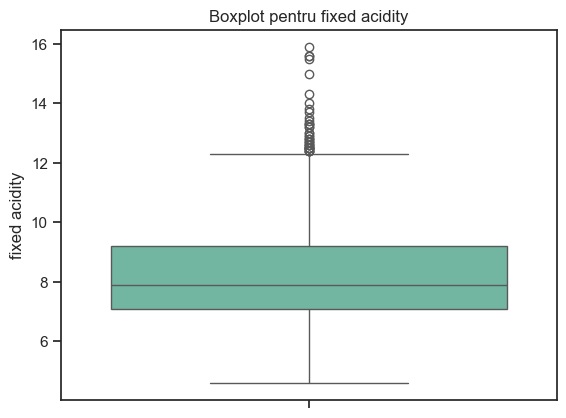

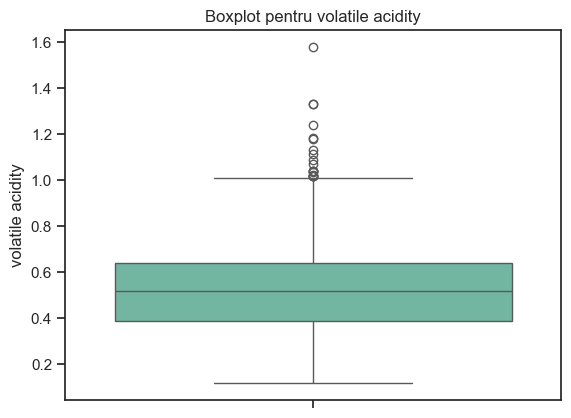

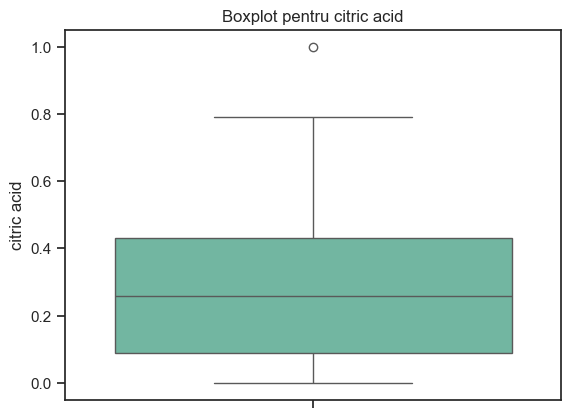

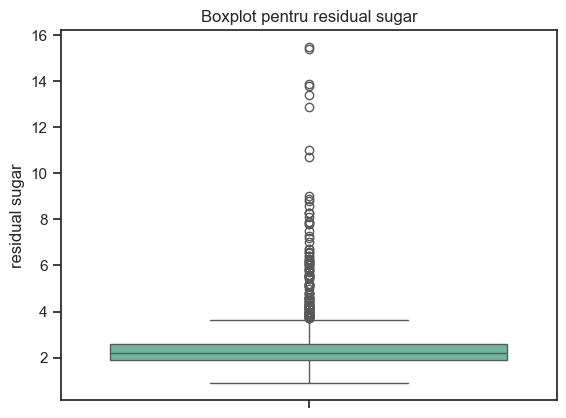

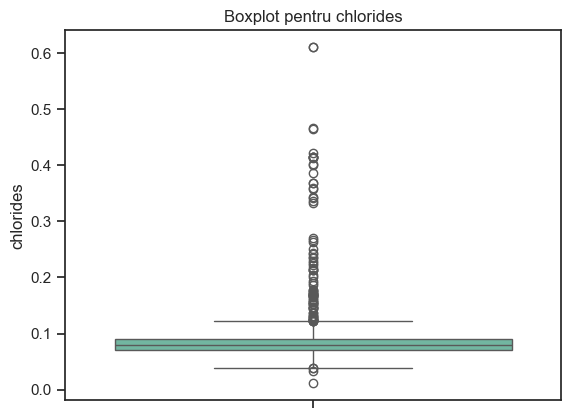

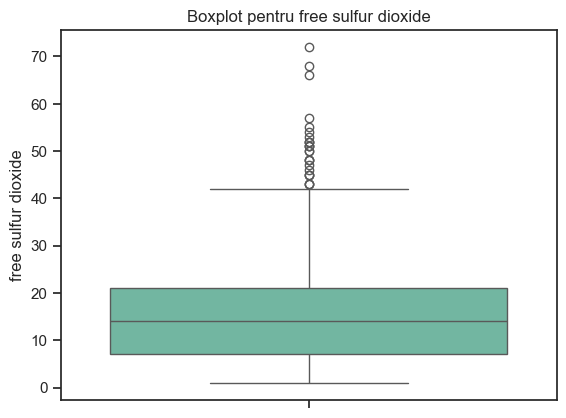

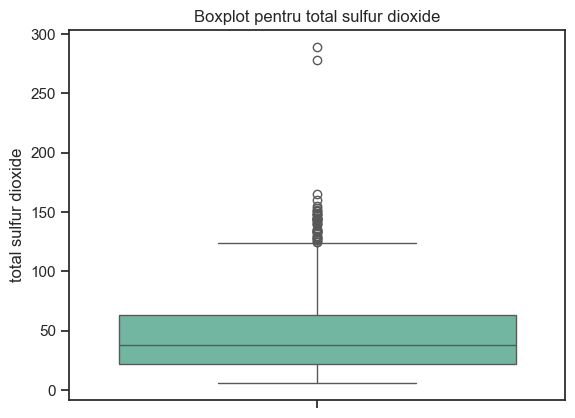

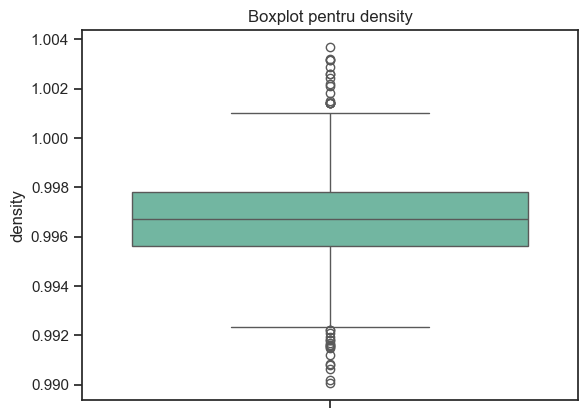

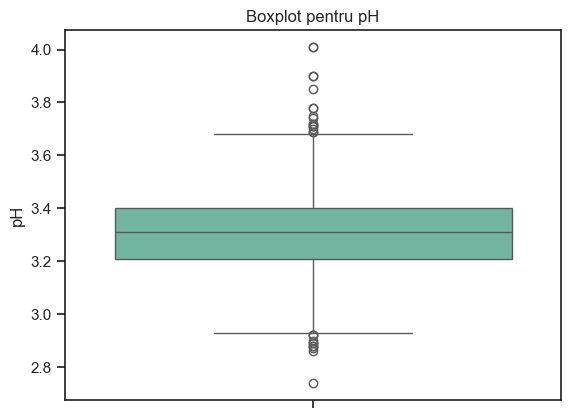

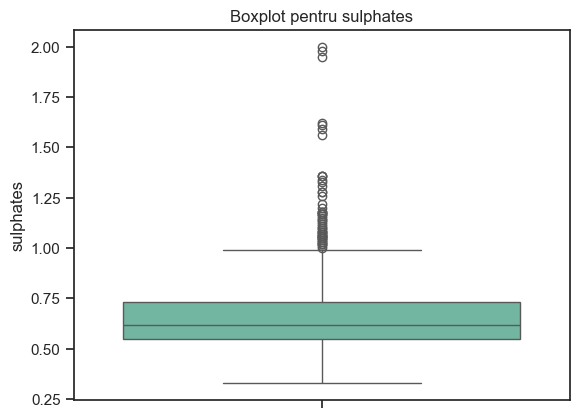

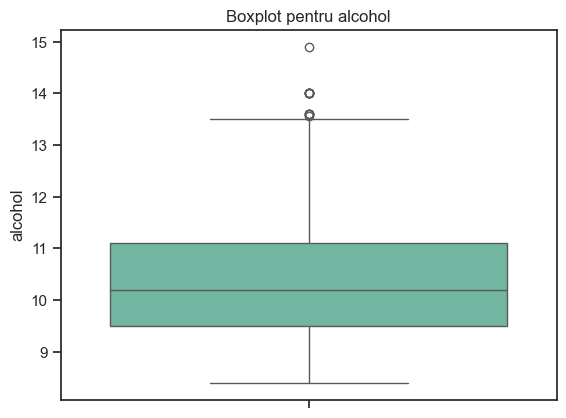

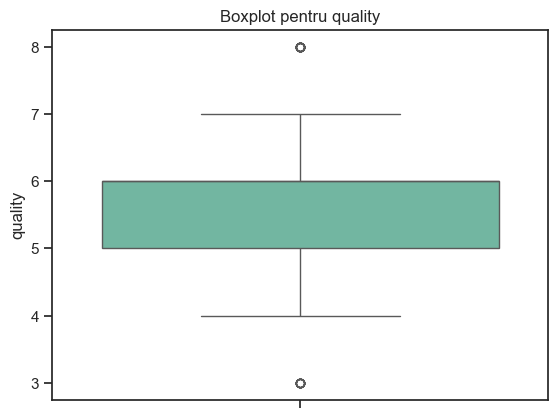

In [5]:

# Histograme pentru variabile
df.drop(columns=['quality', 'quality_grouped']).hist(bins=15, figsize=(15, 10))
plt.suptitle("Histogramele caracteristicilor")
plt.tight_layout()
plt.show()

# Boxploturi pentru outlieri
for col in df.select_dtypes(include='number').columns:
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot pentru {col}')
    plt.show()


Acuratețe: 0.8161764705882353
Raport de clasificare:
               precision    recall  f1-score   support

        high       0.50      0.05      0.10        37
         low       0.00      0.00      0.00        13
       mediu       0.82      0.99      0.90       222

    accuracy                           0.82       272
   macro avg       0.44      0.35      0.33       272
weighted avg       0.74      0.82      0.75       272



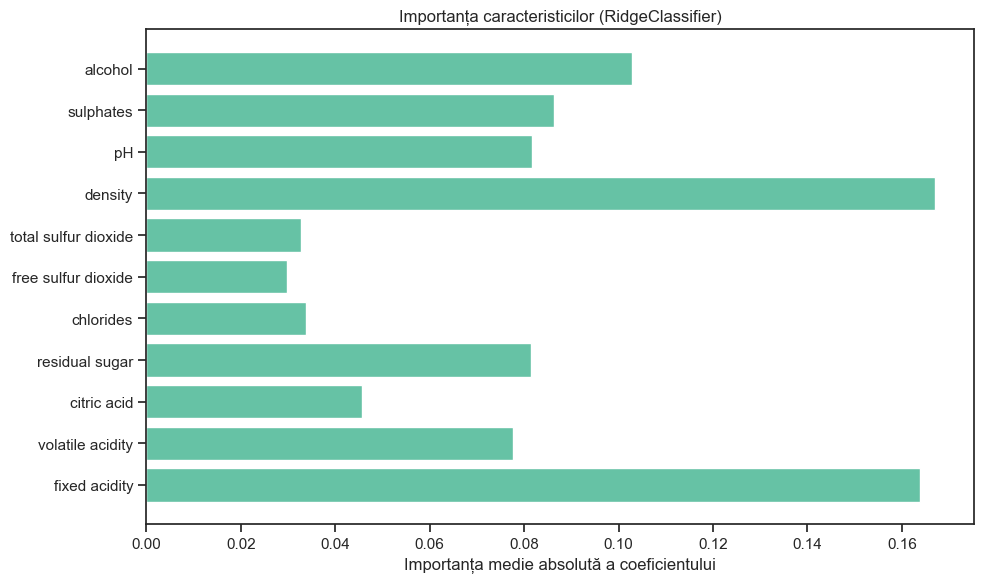

In [6]:

# Model RidgeClassifier
model = RidgeClassifier()
model.fit(X_train, y_train)

# Predicții
y_pred = model.predict(X_test)

print("Acuratețe:", accuracy_score(y_test, y_pred))
print("Raport de clasificare:\n", classification_report(y_test, y_pred, zero_division=0))

# Importanță caracteristici
importance = np.abs(model.coef_).mean(axis=0)
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Importanța medie absolută a coeficientului")
plt.title("Importanța caracteristicilor (RidgeClassifier)")
plt.tight_layout()
plt.show()


alcohol                 0.480343
sulphates               0.248835
citric acid             0.228057
fixed acidity           0.119024
residual sugar          0.013640
free sulfur dioxide    -0.050463
pH                     -0.055245
chlorides              -0.130988
total sulfur dioxide   -0.177855
density                -0.184252
volatile acidity       -0.395214
Name: quality, dtype: float64


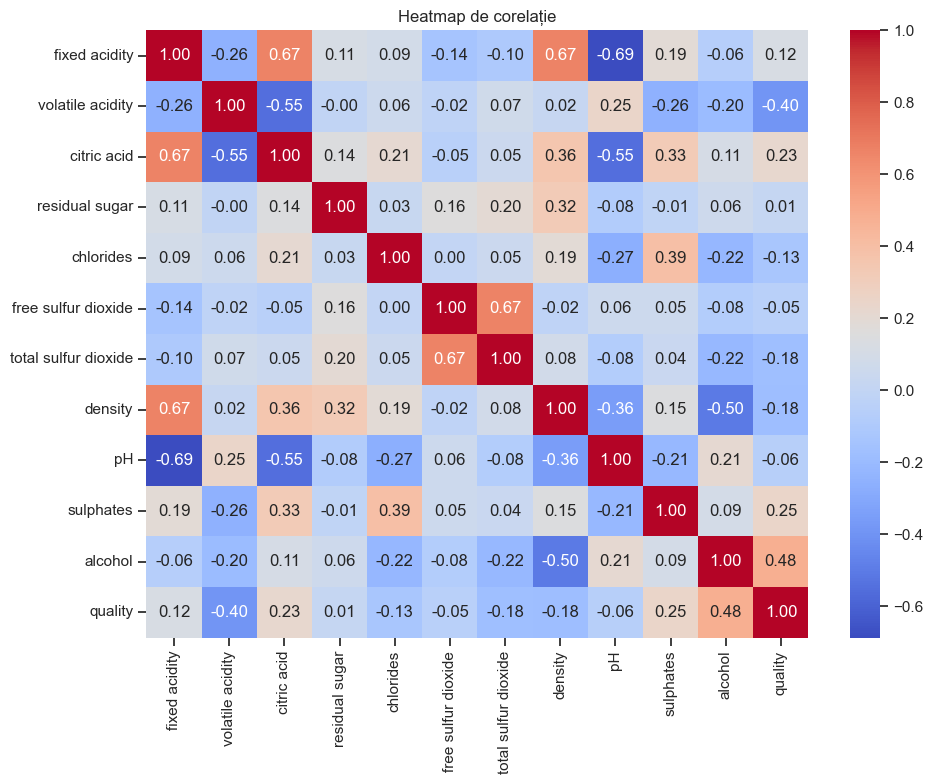

In [7]:

# Corelații numerice
numerice_df = df.select_dtypes(include='number')
correlations = numerice_df.corr()['quality'].drop('quality').sort_values(ascending=False)
print(correlations)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numerice_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de corelație")
plt.tight_layout()
plt.show()


In [8]:

# PCA
X_pca = numerice_df.drop(columns=["quality"])
X_scaled = StandardScaler().fit_transform(X_pca)

pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# SelectKBest
y_num = numerice_df["quality"]
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_pca, y_num)
scores = pd.Series(selector.scores_, index=X_pca.columns)
print("Cele mai relevante variabile:\n", scores.sort_values(ascending=False))


Explained variance ratio: [0.28293989 0.17347505 0.14066813]
Cele mai relevante variabile:
 alcohol                 103.437849
volatile acidity         53.444371
total sulfur dioxide     23.025815
sulphates                18.537139
citric acid              16.290843
density                  12.857528
chlorides                 5.401693
fixed acidity             5.185218
free sulfur dioxide       4.792748
pH                        4.377319
residual sugar            1.139565
dtype: float64


In [9]:
# Optimizarea performantelor modelului - Tema 1
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [10]:
df = pd.read_csv("dataset/winequality-red.csv", sep=";")

def grupare_calitate(x):
    if x <= 4:
        return "slab"
    elif x <= 6:
        return "mediu"
    else:
        return "bun"

df["calitate"] = df["quality"].apply(grupare_calitate)
X = df.drop(columns=["quality", "calitate"])
y = df["calitate"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
model_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeClassifier())
])

parametri_ridge = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(model_ridge, parametri_ridge, cv=5, scoring="accuracy")
grid_ridge.fit(X_train, y_train)
y_pred_ridge = grid_ridge.best_estimator_.predict(X_test)

print("=== RidgeClassifier ===")
print("Cea mai buna valoare alpha:", grid_ridge.best_params_["ridge__alpha"])
print("Acuratete pe setul de test:", round(accuracy_score(y_test, y_pred_ridge), 4))
print(classification_report(y_test, y_pred_ridge, zero_division=0))


=== RidgeClassifier ===
Cea mai buna valoare alpha: 10
Acuratete pe setul de test: 0.8313
              precision    recall  f1-score   support

         bun       0.60      0.14      0.23        43
       mediu       0.84      0.98      0.91       264
        slab       0.00      0.00      0.00        13

    accuracy                           0.83       320
   macro avg       0.48      0.37      0.38       320
weighted avg       0.77      0.83      0.78       320



In [12]:
parametri_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), parametri_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.best_estimator_.predict(X_test)

print("=== RandomForestClassifier ===")
print("Cei mai buni parametri:", grid_rf.best_params_)
print("Acuratete pe setul de test:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf, zero_division=0))

=== RandomForestClassifier ===
Cei mai buni parametri: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Acuratete pe setul de test: 0.8688
              precision    recall  f1-score   support

         bun       0.73      0.56      0.63        43
       mediu       0.89      0.96      0.92       264
        slab       0.00      0.00      0.00        13

    accuracy                           0.87       320
   macro avg       0.54      0.51      0.52       320
weighted avg       0.83      0.87      0.85       320



In [13]:

parametri_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), parametri_gb, cv=5, scoring="accuracy", n_jobs=-1)
grid_gb.fit(X_train, y_train)
y_pred_gb = grid_gb.best_estimator_.predict(X_test)

print("=== GradientBoostingClassifier ===")
print("Cei mai buni parametri:", grid_gb.best_params_)
print("Acuratete pe setul de test:", round(accuracy_score(y_test, y_pred_gb), 4))
print(classification_report(y_test, y_pred_gb, zero_division=0))


=== GradientBoostingClassifier ===
Cei mai buni parametri: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Acuratete pe setul de test: 0.8656
              precision    recall  f1-score   support

         bun       0.68      0.63      0.65        43
       mediu       0.90      0.95      0.92       264
        slab       0.00      0.00      0.00        13

    accuracy                           0.87       320
   macro avg       0.52      0.52      0.52       320
weighted avg       0.83      0.87      0.85       320

